In [1]:
from mpl_toolkits.mplot3d import Axes3D
from rtree import index
import xgboost as xgb
import pickle
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [2]:
%store -r mc_data

In [3]:
###### Data columns
i = 0
for val in mc_data.columns:
    print(i," ",val)
    i = i + 1

0   MCParticleID
1   MC_Hit_X
2   MC_Hit_Y
3   MC_Hit_Z
4   PrHit_LHCbID
5   PrHit_Xat0
6   PrHit_Zat0
7   PrHit_isX
8   PrHit_planeCode
9   PrHit_w2
10   PrHit_yMax
11   PrHit_yMin
12   PrHit_zone
13   event
14   hasT
15   isInUT
16   isInVelo
17   isLong
18   isLong_fromB
19   isLong_fromB_more5
20   isLong_more5


In [4]:
mc_hits = mc_data.values

In [5]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        xlayer_model = load_model('./models/xlayer_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [61]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        tracks_classifier = load_model('./models/track_classifier_all_stations_v2.h5')

In [7]:
%store -r zLays
%store -r max_x
%store -r min_x
%store -r max_y
%store -r min_y
%store -r events

In [8]:
print(events)

[15837 15838 15839 15840 15841 15842 15843 15844 15845 15846 15847 15848
 15849 15850 15851 15852 15853 15854 15855 15856 15857 15858 15859 15860
 15861 15862 15863 15864 15865 15866 15867 15868 15869 15870 15871 15872
 15873 15874 15875 15876 15877 15878 15879 15880 15881 15882 15883 15884
 15885 15886 15887 15888 15889 15890 15891 15892 15893 15894 15895 15896
 15897 15898 15899 15900 15901 15902 15903 15904 15905 15906 15907 15908
 15909 15910 15911 15912 15913 15914 15915 15916 15917 15918 15919 15920
 15921 15922 15923 15924 15925 15926 15927 15928 15929 15930 15931 15932
 15933 15934 15935 15936 15937 15938 15939 15940 15941 17909 17910 17911
 17912 17913 17914 17915 17916 17917 17918 17919 17920 17921 17922 17923
 17924 17925 17926 17927 17928 17929 17930 17931 17932 17933 17934 17935
 17936 17937 17938 17939 17940 17941 17942 17943 17944 17945 17946 17947
 17948 17949 17950 17951 17952 17953 17954 17955 17956 17957 17958 17959
 17960 17961 17962 17963 17964 17965 17966 17967 17

In [9]:
def histogram(data, color, min, max, title, x_axis, y_axis):
    fig = plt.figure(figsize=(19, 10))
    ax = fig.add_subplot(111)
    
    textstr = '$\mu=%.3f$\n$\sigma=%.3f$\n$n=%.0f$'%(np.mean(np.array(data)), np.std(np.array(data)), len(data))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=18,
            verticalalignment='top', bbox=props)

    n, bins, patches = plt.hist(data, 100, facecolor=color, range=(min,max))
    ax.set_title('%s\n' % title)
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    ax.grid()
    plt.show()

In [10]:
def predictHeight(x0, x3, x_stereo, stereo_layer, first_layer, last_layer):
    
    z_stereo = zLays[stereo_layer]
    
    if (stereo_layer % 2 != 0):
        angle = 5
    else:
        angle = -5
        
    m = float(zLays[last_layer] - zLays[first_layer]) / float(x3 - x0)
    n = zLays[last_layer] - (m * x3)
    
    x_pred = (z_stereo - n) / m 
    beta = (x_pred - x_stereo) / (math.radians(angle) * z_stereo)
    return math.tan(beta) * z_stereo

In [11]:
def selectValidTrack(valid_tracks):
    
    selected = None
    if (len(valid_tracks) > 1):
        for track in valid_tracks:
            found = 0
            for other_track in valid_tracks:
                if (track[0][4][0] in other_track[0][4]):
                    found += 1
                if (track[0][4][1] in other_track[0][4]):
                    found += 1
                if (track[0][4][2] in other_track[0][4]):
                    found += 1
                if (track[1][4][0] in other_track[1][4]):
                    found += 1
                if (track[1][4][1] in other_track[1][4]):
                    found += 1
                if (track[1][4][2] in other_track[1][4]):
                    found += 1
                if (track[2][4][0] in other_track[2][4]):
                    found += 1
                if (track[2][4][1] in other_track[2][4]):
                    found += 1
                if (track[2][4][2] in other_track[2][4]):
                    found += 1
                if (found > 5):
                    valid_tracks.remove(other_track);
        if (len(valid_tracks) < 2):
            selected = valid_tracks[0]
        
    return selected

In [12]:
def validateTrack(track, particle):
    found = 0
    if (not track is None):
        for station in track:
            for id in station[4]:
                if id in particle[4]:
                    found += 1
                
    return (found > 5)

In [13]:
def selectValidTrack_NN(valid_tracks):
    max = 0
    selected = None
    if (len(valid_tracks) > 0):
        selected = valid_tracks[0]
        for track in valid_tracks:
            pred = tracks_classifier.predict(np.array(track[0][:4] + track[1][:4] + track[2][:4]).reshape(1,-1))
            if (pred > max):
                max = pred
                selected = track
    return selected

In [74]:
#
# Test the NN model by using events not feeded as train 
#

def trackReconstruction(particles_test_event, index_tree):
    
    # Variables used for calculating metrics
    total_found = 0
    total = 0
    ghost = 0
    mean_size = np.zeros(3)
    
    # Variable defining the maximum number of hits gathered from the R-trees when using the predicted value from the NN
    max_hits_gathered = 12

    # Range in which valid hits are look up in the first R-tree
    long_range = 300
    
    X_real_data = []
    X_fake_data = []

    # For each particle of a given event
    for particle in particles_test_event:
        
        # Sometimes there are no PrHits for a given particle, so skip these ones
        if (len(particle[5]) > 1) and (particle[0] != 11) and (particle[0] != -11) and particle[20]:
            
            found_num = 0            
            X_final = {}
            Zone_final = {}
            actual = -1

            # Extract all PrHits
            for i in range(0, len(particle[5])):
                if (actual != particle[8][i]):
                    X_final[particle[8][i]] = []
                    X_final[particle[8][i]].append(particle[5][i])
                    Zone_final[particle[8][i]] = particle[12][i]
                    actual = particle[8][i]
                    found_num += 1
                else:
                    X_final[actual].append(particle[5][i])

            # Check if there are minimum 12 hits found, as for the test, I am only working with complete tracks
            if (found_num < 12):
                continue
            
            # List used to iterate over valid height found later on
            valid_y = {}
            
            # For each station
            for station in range(0,3):
                
                valid_y[station] = []
                
                # Compute the layer number based on station
                x0_layer = 0
                if (station == 1):
                    x0_layer = 4
                elif station == 2:
                    x0_layer = 8

                u_layer = x0_layer + 1
                v_layer = x0_layer + 2
                x1_layer = x0_layer + 3
                
                # Select both the first X position and UP/DOWN based on this
                first_hit = X_final[x0_layer][0]
                zone = Zone_final[x0_layer]

                # Predict all 3 following points based on the first hit selected
                predicted = (xlayer_model.predict(np.array([first_hit, x0_layer]).reshape(1,-1)))[0]
                mean_predicted = ((first_hit + predicted[0] + predicted[1] + predicted[2]) / 4)

                # Recolect all nearest hits from each layer using R-trees based on the X-position of the mean predicted
                if (x1_layer in X_final):
                    found = list(index_tree.nearest((mean_predicted - long_range, mean_predicted + long_range, x1_layer, x1_layer, zone, zone), objects='raw'))
                    found_layer3 = sorted(found, key=lambda x: np.abs(x[0]- mean_predicted))[:max_hits_gathered]
                    arr_layer3 = np.unique(np.array(found_layer3), axis=0)

                if (v_layer in X_final):
                    found = list(index_tree.nearest((mean_predicted - long_range, mean_predicted + long_range, v_layer, v_layer, zone, zone), objects='raw'))
                    found_layer2 = sorted(found, key=lambda x: np.abs(x[0] - mean_predicted))[:max_hits_gathered]
                    arr_layer2 = np.unique(np.array(found_layer2), axis=0)
                    
                if (u_layer in X_final):
                    found = list(index_tree.nearest((mean_predicted - long_range, mean_predicted + long_range, u_layer, u_layer, zone, zone), objects='raw'))
                    found_layer1 = sorted(found, key=lambda x: np.abs(x[0] - mean_predicted))[:max_hits_gathered]
                    arr_layer1 = np.unique(np.array(found_layer1), axis=0)

                # Now, for each hit found in the last layer, as it is the one with most precision, 
                # tracks are searched
                for h3 in arr_layer3:
                    
                    # Sometimes a hit in the last layer is equal to the first one
                    if (h3[0] == first_hit):
                        continue
                        
                    for h2 in arr_layer2:
                                                    
                        # Predict height for each hit selected in the V layer
                        pred_h2 = predictHeight(first_hit, h3[0], h2[0], v_layer, x0_layer, x1_layer)
                        if (pred_h2 > 0) and (pred_h2 > max_y) or (pred_h2 < 0) and (pred_h2 < min_y):
                            continue
                        
                        # And for each hit in the V layer, we look up at hits in the U layer with the same height
                        for h1 in arr_layer1:
                            
                            # Predict height for hit in the U layer
                            pred_h1 = predictHeight(first_hit, h3[0], h1[0], u_layer, x0_layer, x1_layer)
                            if (pred_h1 > 0) and (pred_h1 > max_y) or (pred_h1 < 0) and (pred_h1 < min_y):
                                continue
                            
                            #if (h3[1] in particle[4] and h2[1] in particle[4] and h1[1] in particle[4]):
                            #    X_real_data.append(np.abs(pred_h2 - pred_h1))
                                
                            # Compare then, if the combination of U+V+X makes sense based on the height.
                            # As they usually have a slight difference between them, so only if the height is similar
                            # it is considered a valid track
                            if np.abs(pred_h2 - pred_h1) < 15.5:
                                # Insert into a new R-tree to enable search by height
                                # Store the valid height for later iterate over it
                                valid_y[station].append([h1[0], h2[0], h3[0], pred_h2, (h1[1],h2[1],h3[1])])
            
            valid_tracks = []
            for val in valid_y[0]:
                if (len(valid_y[1]) > 0 and len(valid_y[2]) > 0):
                    second_sort = sorted(valid_y[1], key = lambda p: np.abs(p[3] - val[3]))
                    #if (second_sort[0][4][0] in particle[4] and second_sort[0][4][1] in particle[4] and second_sort[0][4][2] in particle[4]):
                    #    X_real_data.append((second_sort[0][3] - val[3]))
                    #else:
                    #    X_fake_data.append((second_sort[0][3] - val[3]))
                    if (np.abs(second_sort[0][3] - val[3]) < 120):
                        third_sort = sorted(valid_y[2], key = lambda p: np.abs(p[3] - second_sort[0][3]))
                        if (third_sort[0][4][0] in particle[4] and third_sort[0][4][1] in particle[4] and third_sort[0][4][2] in particle[4]):
                            X_real_data.append(third_sort[0][3] - second_sort[0][3])
                        else:
                            X_fake_data.append(third_sort[0][3] - second_sort[0][3])
                        if np.abs(third_sort[0][3] - second_sort[0][3]) < 100:
                            valid_tracks.append([val, second_sort[0], third_sort[0]])
            
            
            track = selectValidTrack_NN(valid_tracks)
            if (validateTrack(track, particle)):
                total_found += 1
            elif not track is None:
                ghost += 1
                
            total += 1

    #print("\nMean Total Found: %f" % (total_found/total))
    #print("\nMean Size: %f" % (mean_size[0]/total))
    return (total_found/total, ghost/total, X_real_data, X_fake_data)
    

In [ ]:
mean = done = ghosts = 0
test_events = events[:20]

p = index.Property()
p.dimension = 3
X_real_data = []
X_fake_data = []

for event in test_events:
    particles_test_event = mc_hits[mc_hits[:,13] == event]
    mean_val = size_val = 0
    
    index_tree = index.Index(properties=p, interleaved=False)
    
    for hit in particles_test_event:
        if (len(hit[5]) > 1) and (hit[0] != 11) and (hit[0] != -11) and hit[20]:
            for i in range(0,len(hit[5])):
                index_tree.insert(int(hit[4][i]), (float(hit[5][i]), float(hit[5][i]), hit[8][i], hit[8][i], hit[12][i], hit[12][i]), [float(hit[5][i]), int(hit[4][i])])

    mean_val, ghost_val, X1, X2 = trackReconstruction(particles_test_event, index_tree)
    
    mean += mean_val
    ghosts += ghost_val
    done += 1
    
    X_real_data += X1
    X_fake_data += X2
    
    print("Event %d/%d \t Acc: %f Ghost: %f" % (done,len(test_events), mean_val, ghost_val))
    
print("\nFinal Result:")
print("\t Mean: %f" % (mean/len(test_events)))
print("\t Ghosts: %f" % (ghosts/len(test_events)))

Event 1/20 	 Acc: 1.000000 Ghost: 0.000000
Event 2/20 	 Acc: 0.961538 Ghost: 0.000000
Event 3/20 	 Acc: 0.913043 Ghost: 0.000000
Event 4/20 	 Acc: 0.947368 Ghost: 0.000000
Event 5/20 	 Acc: 0.921053 Ghost: 0.026316
Event 6/20 	 Acc: 1.000000 Ghost: 0.000000
Event 7/20 	 Acc: 0.928571 Ghost: 0.000000
Event 8/20 	 Acc: 1.000000 Ghost: 0.000000
Event 9/20 	 Acc: 1.000000 Ghost: 0.000000
Event 10/20 	 Acc: 0.882353 Ghost: 0.058824
Event 11/20 	 Acc: 1.000000 Ghost: 0.000000
Event 12/20 	 Acc: 0.933333 Ghost: 0.000000
Event 13/20 	 Acc: 1.000000 Ghost: 0.000000
Event 14/20 	 Acc: 1.000000 Ghost: 0.000000
Event 15/20 	 Acc: 0.954545 Ghost: 0.000000
Event 16/20 	 Acc: 1.000000 Ghost: 0.000000
Event 17/20 	 Acc: 0.961538 Ghost: 0.038462


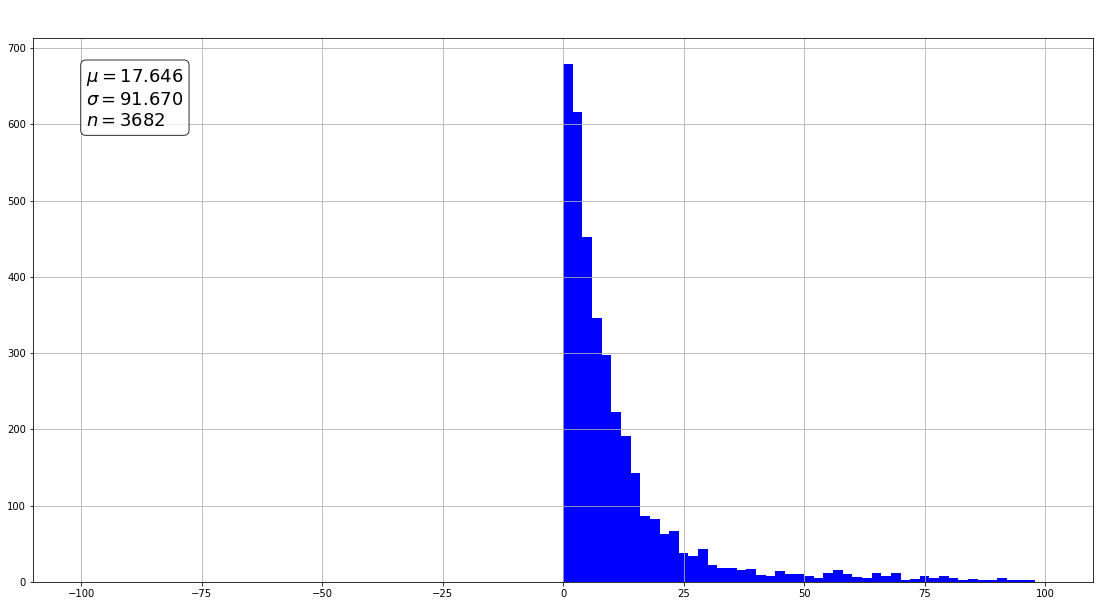

In [32]:
histogram(X_real_data, 'blue', -100, 100, '','','')

In [ ]:
Particles with all hits
    All Hits:
        120 - 100
        Final Result:
             Mean: 0.761302
             Ghosts: 0.068680

        100 - 100
        Final Result:
             Mean: 0.759360
             Ghosts: 0.065982

        NN - v2
        Final Result:
             Mean: 0.779410
             Ghosts: 0.050571

    Long only:
        Final Result:
             Mean: 0.939262
             Ghosts: 0.008252

    Long P > 5 GeV/c
        Final Result:
             Mean: 0.965544
             Ghosts: 0.007200

    

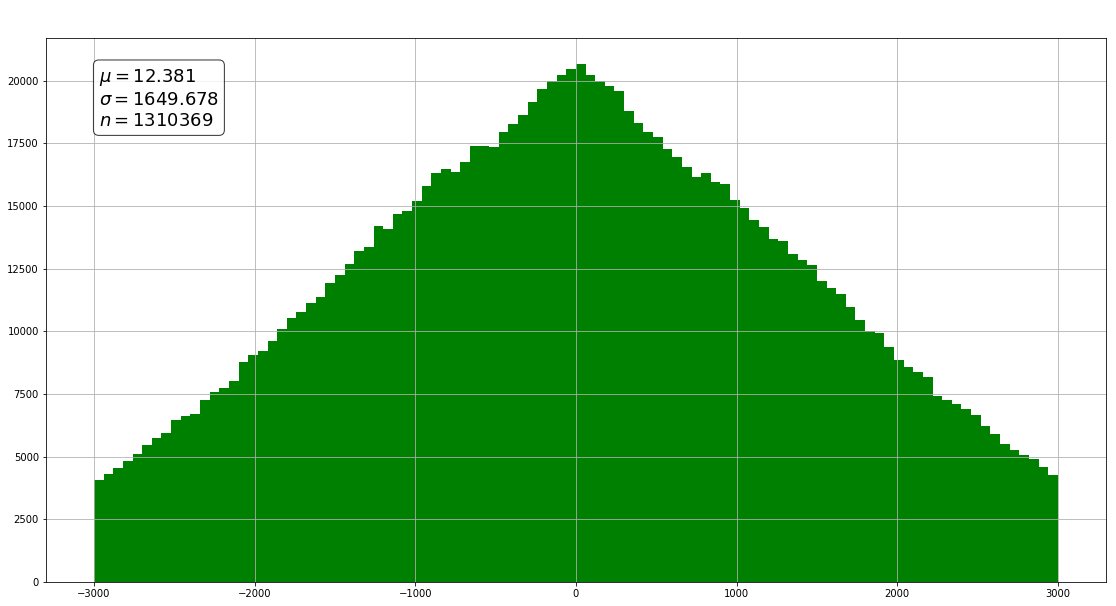

In [33]:
histogram(X_fake_data, 'green', -3000, 3000, '','','')

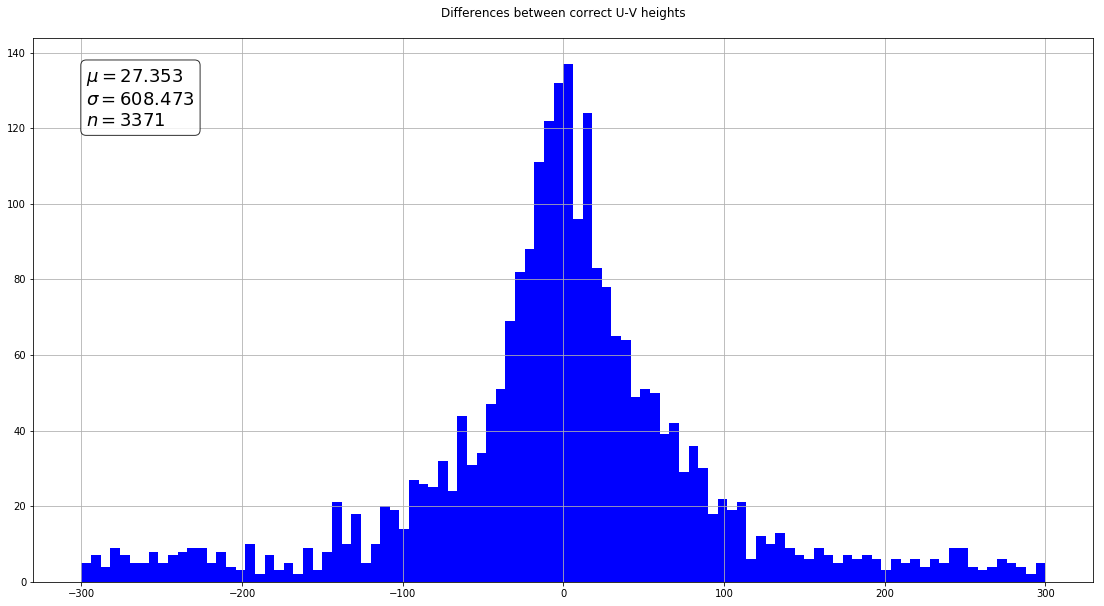

In [53]:
histogram(X_real_data, 'blue', -300, 300, 'Differences between correct U-V heights','','')

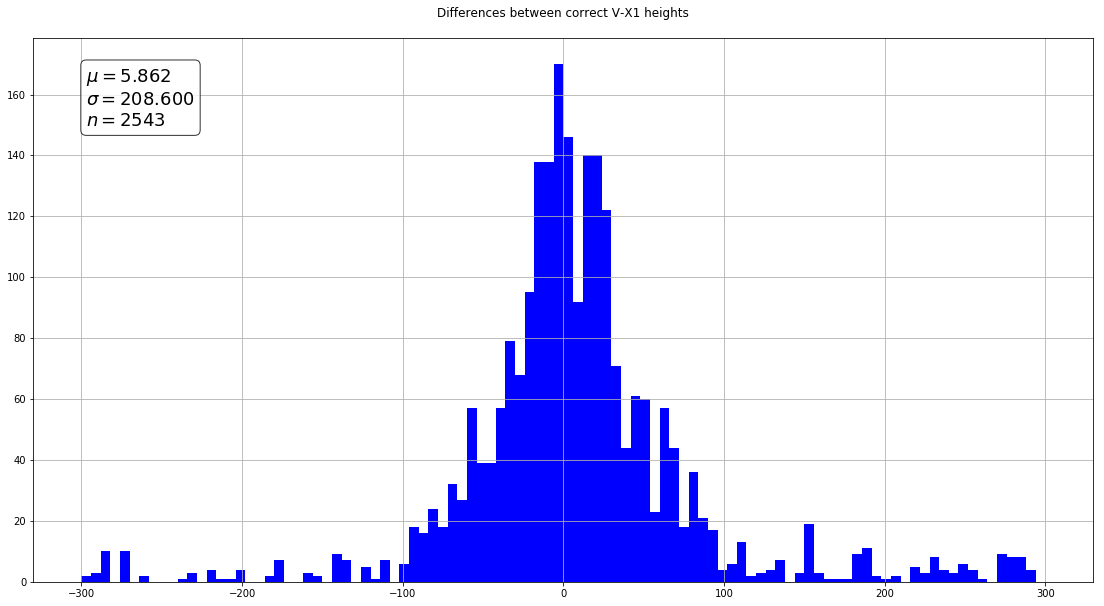

In [56]:
histogram(X_real_data, 'blue', -300, 300, 'Differences between correct V-X1 heights','','')